In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set random seeds for reproducibility
tf.random.set_seed(0)
np.random.seed(0)

# --------------------------
# Sparse Recurrent Connections
# --------------------------
class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, prob_connection, units):
        """
        Constructs a fixed binary mask for recurrent weights
        Args:
            prob_connection (float): Desired connection probability
            units (int): Number of GRU units
        """
        self.prob_connection = prob_connection
        self.units = units
        # Create a base mask of shape (units, units)
        base_mask = np.random.rand(units, units) < prob_connection
        self.base_mask = tf.constant(base_mask.astype(np.float32))
    
    def __call__(self, w):
        # w with shape (units, m) where m is a multiple of units
        m = w.shape[1]

        # Determine how many times to tile the base mask
        factor = m // self.units  
        mask_tiled = tf.tile(self.base_mask, [1, factor])
        return w * mask_tiled
    
    def get_config(self):
        return {'prob_connection': self.prob_connection, 'units': self.units}

# --------------------------
# Helper function: Metrics plot
# --------------------------
def plot_metrics(total_rewards, actor_losses, critic_losses, window_1=10, window_2=25):
    """
    Plots the raw metrics and their rolling statistics over windows of window_1 and window_2 episodes
    Each column corresponds to one metric:
      - Column 1: Total Reward
      - Column 2: Actor Loss
      - Column 3: Critic Loss
    Row 1: Raw metrics
    Row 2: Rolling mean, median, and std over a window of window_1 episodes
    Row 3: Rolling mean, median, and std over a window of window_2 episodes
    """

    def plot_rolling(ax, data, window, label):
        series = pd.Series(data)
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        rolling_median = series.rolling(window=window, min_periods=1).median()
        rolling_std = series.rolling(window=window, min_periods=1).std()
        ax.plot(episodes, rolling_mean, label="Mean")
        ax.plot(episodes, rolling_median, label="Median")
        ax.fill_between(episodes, rolling_mean - rolling_std, rolling_mean + rolling_std,
                        alpha=0.2, label="Std")
        ax.set_title(f"Rolling (window={window}) {label}")
        ax.set_xlabel("Episode")
        ax.legend()

    episodes = range(1, len(total_rewards) + 1)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    axs[0, 0].plot(episodes, total_rewards, label="Raw")
    axs[0, 0].set_title("Raw Total Reward")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].legend()
    
    axs[0, 1].plot(episodes, actor_losses, label="Raw", color="tab:orange")
    axs[0, 1].set_title("Raw Actor Loss")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Actor Loss")
    axs[0, 1].legend()
    
    axs[0, 2].plot(episodes, critic_losses, label="Raw", color="tab:green")
    axs[0, 2].set_title("Raw Critic Loss")
    axs[0, 2].set_xlabel("Episode")
    axs[0, 2].set_ylabel("Critic Loss")
    axs[0, 2].legend()
    
    plot_rolling(axs[1, 0], total_rewards, window_1, "Total Reward")
    plot_rolling(axs[1, 1], actor_losses, window_1, "Actor Loss")
    plot_rolling(axs[1, 2], critic_losses, window_1, "Critic Loss")
    
    plot_rolling(axs[2, 0], total_rewards, window_2, "Total Reward")
    plot_rolling(axs[2, 1], actor_losses, window_2, "Actor Loss")
    plot_rolling(axs[2, 2], critic_losses, window_2, "Critic Loss")
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Helper function: Discount reward
# --------------------------
def discount_rewards(rewards, gamma):
    """
    Computes discounted rewards.
    Args:
        rewards (list): List of rewards collected in an episode.
        gamma (float): Discount factor.
    Returns:
        np.array: Discounted rewards.
    """
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0.0
    for i in reversed(range(len(rewards))):
        cumulative = rewards[i] + gamma * cumulative
        discounted[i] = cumulative
    return discounted

# --------------------------
# Actor (Policy) Network
# --------------------------
class ActorModel(Model):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 num_layers=1,
                 prob_connection=0.1):
        """
        Actor network that uses GRU layers to output action probabilities
        Args:
            input_size (int): Dimensionality of the observations (states)
            hidden_size (int): Number of GRU units
            output_size (int): Number of actions
            num_layers (int): Number of GRU layers
            prob_connection (float): Connection probability for recurrent weights
        """
        super(ActorModel, self).__init__()
        self.num_layers = num_layers
        self.gru_layers = []
        for i in range(num_layers):
            recurrent_constraint = None

            # If the probability is less than 1.0, a sparse mask is applied
            if prob_connection < 1.0:
                recurrent_constraint = SparseConstraint(prob_connection, hidden_size)
            
            self.gru_layers.append(layers.GRU(hidden_size,
                                              activation=tf.nn.tanh,
                                              recurrent_activation=tf.nn.sigmoid,
                                              return_sequences=True,
                                              return_state=True,
                                              recurrent_constraint=recurrent_constraint))
        self.fc = layers.Dense(output_size)

    def call(self, inputs, hidden_states=None, training=None):
        output = inputs
        new_states = []
        for i, gru in enumerate(self.gru_layers):
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)
        logits = self.fc(output[:, -1, :])
        probs = tf.nn.softmax(logits, axis=-1)
        return probs, new_states

# --------------------------
# Critic (Value) Network
# --------------------------
class CriticModel(Model):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 prob_connection=1.0):
        """
        Critic network that uses GRU layers to output a scalar value estimate
        Args:
            input_size (int): Dimensionality of the observations
            hidden_size (int): Number of GRU units
            num_layers (int): Number of GRU layers
            prob_connection (float): Connection probability for recurrent weights
        """
        super(CriticModel, self).__init__()
        self.num_layers = num_layers
        self.gru_layers = []
        for i in range(num_layers):
            recurrent_constraint = None

            # If the probability is less than 1.0, a sparse mask is applied
            if prob_connection < 1.0:
                recurrent_constraint = SparseConstraint(prob_connection, hidden_size)

            self.gru_layers.append(layers.GRU(hidden_size,
                                              activation=tf.nn.tanh,
                                              recurrent_activation=tf.nn.sigmoid,
                                              return_sequences=True,
                                              return_state=True,
                                              recurrent_constraint=recurrent_constraint))
        self.fc = layers.Dense(1)

    def call(self, inputs, hidden_states=None, training=None):
        output = inputs
        new_states = []
        for i, gru in enumerate(self.gru_layers):
            current_state = hidden_states[i] if hidden_states is not None else None
            output, state = gru(output, initial_state=current_state, training=training)
            new_states.append(state)
        value = self.fc(output[:, -1, :])
        return value, new_states

# --------------------------
# Actor-Critic Agent
# --------------------------
class ActorCriticAgent:
    def __init__(self,
                 obs_size,
                 act_size,
                 actor_hidden_size=128,
                 critic_hidden_size=128,
                 actor_layers=1,
                 critic_layers=1,
                 actor_lr=1e-3,
                 critic_lr=1e-3,
                 noise_std=0.0,
                 actor_prob_connection=0.1,
                 critic_prob_connection=1.0):
        """
        Container for the actor and critic networks and their optimizers
        Args:
            obs_size (int): Dimension of observations
            act_size (int): Number of actions
            actor_hidden_size (int): Number of hidden units in the actor GRU
            critic_hidden_size (int): Number of hidden units in the critic GRU
            actor_layers (int): Number of GRU layers in the actor
            critic_layers (int): Number of GRU layers in the critic
            actor_lr (float): Learning rate for the actor
            critic_lr (float): Learning rate for the critic
            noise_std (float): Standard deviation of Gaussian noise added to the input state
            actor_prob_connection (float): Connection probability for actor's recurrent weights
            critic_prob_connection (float): Connection probability for critic's recurrent weights
        """
        self.actor = ActorModel(
            input_size=obs_size,
            hidden_size=actor_hidden_size,
            output_size=act_size,
            num_layers=actor_layers,
            prob_connection=actor_prob_connection
        )
        self.critic = CriticModel(
            input_size=obs_size,
            hidden_size=critic_hidden_size,
            num_layers=critic_layers,
            prob_connection=critic_prob_connection
        )
        self.actor_optimizer = optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = optimizers.Adam(learning_rate=critic_lr)
        self.noise_std = noise_std

    def add_noise(self, state):
        """
        Adds Gaussian noise to the state if noise_std is non-zero
        Args:
            state (np.array): Original state
        Returns:
            np.array: Noisy state
        """
        if self.noise_std != 0.0:
            return state + np.random.normal(0, self.noise_std, size=state.shape)
        return state

    def select_action(self, state, actor_hidden_states=None, training=True):
        """
        Selects an action based on the actor network
        Args:
            state (np.array): Current observation (1D array)
            actor_hidden_states: Hidden states for the actor GRU (optional)
            training (bool): Flag indicating training mode
        Returns:
            action (int): Selected action
            log_prob (tf.Tensor): Log probability of the selected action
            new_actor_hidden_states: Updated hidden states for the actor
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)
        probs, new_actor_hidden_states = self.actor(state_tensor, hidden_states=actor_hidden_states, training=training)
        action = tf.random.categorical(tf.math.log(probs), num_samples=1)
        action = tf.squeeze(action, axis=-1)
        action_one_hot = tf.one_hot(action, depth=probs.shape[-1])
        log_prob = tf.math.log(tf.reduce_sum(probs * action_one_hot, axis=-1))
        return int(action[0].numpy()), log_prob, new_actor_hidden_states

    def evaluate_state(self, state, critic_hidden_states=None, training=True):
        """
        Evaluates the state value using the critic network
        Args:
            state (np.array): Current observation
            critic_hidden_states: Hidden state(s) for the critic GRU (optional)
            training (bool): Flag indicating training mode
        Returns:
            value (tf.Tensor): Estimated state value
            new_critic_hidden_states: Updated hidden state(s) for the critic
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)
        state_tensor = tf.expand_dims(state_tensor, axis=1)
        value, new_critic_hidden_states = self.critic(state_tensor, hidden_states=critic_hidden_states, training=training)
        return value[0, 0], new_critic_hidden_states

# --------------------------
# Training using REINFORCE with baseline and regularization
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10, l2_actor=1e-4, l2_critic=1e-4):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples
      2. Compute discounted returns
      3. Re-run the forward passes for both actor and critic inside gradient tapes
      4. Update actor using:
            L_actor = - E[ log(pi(a|s)) * (R - V(s)) ] + L2 regularization term
         and critic using:
            L_critic = E[ (R - V(s))^2 ] + L2 regularization term
    """
    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []

    lambda_actor = l2_actor
    lambda_critic = l2_critic

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        done = False
        states = []
        actions = []
        rewards = []

        while not done:
            action, _, _ = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        with tf.GradientTape() as tape_actor:
            log_probs = []
            for s, a in zip(states, actions):
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                probs, _ = agent.actor(s_tensor, hidden_states=None, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1) + 1e-8)
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            advantage = returns - values
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))
            l2_reg_actor = tf.add_n([tf.nn.l2_loss(v) for v in agent.actor.trainable_variables])
            actor_loss += lambda_actor * l2_reg_actor

        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        with tf.GradientTape() as tape_critic:
            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                s_tensor = tf.expand_dims(s_tensor, axis=1)
                value, _ = agent.critic(s_tensor, hidden_states=None, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            critic_loss = tf.reduce_mean(tf.square(returns - values))
            l2_reg_critic = tf.add_n([tf.nn.l2_loss(v) for v in agent.critic.trainable_variables])
            critic_loss += lambda_critic * l2_reg_critic

        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        if episode % print_interval == 0:
            total_reward = sum(rewards)
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\t"
                  f"Actor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")

        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

    return total_rewards_history, actor_loss_history, critic_loss_history


2025-03-28 14:56:44.317465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743170205.218771  216853 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743170205.466604  216853 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 14:56:47.285538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-03-28 11:10:27.340876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 11.00	Actor Loss: 3.0964	Critic Loss: 24.1847
Episode 20	Total Reward: 15.00	Actor Loss: 1.9716	Critic Loss: 28.2641
Episode 30	Total Reward: 11.00	Actor Loss: 0.2762	Critic Loss: 11.6128
Episode 40	Total Reward: 12.00	Actor Loss: 0.2557	Critic Loss: 8.0136
Episode 50	Total Reward: 13.00	Actor Loss: -0.1464	Critic Loss: 6.6340
Episode 60	Total Reward: 12.00	Actor Loss: -0.1900	Critic Loss: 4.5510
Episode 70	Total Reward: 17.00	Actor Loss: 1.0271	Critic Loss: 10.9569
Episode 80	Total Reward: 10.00	Actor Loss: -0.1947	Critic Loss: 3.7568
Episode 90	Total Reward: 16.00	Actor Loss: 0.2517	Critic Loss: 8.7494
Episode 100	Total Reward: 22.00	Actor Loss: 1.5049	Critic Loss: 13.0510
Episode 110	Total Reward: 8.00	Actor Loss: -1.6354	Critic Loss: 15.6794
Episode 120	Total Reward: 16.00	Actor Loss: -0.0429	Critic Loss: 8.5628
Episode 130	Total Reward: 13.00	Actor Loss: -0.7960	Critic Loss: 5.3338
Episode 140	Total Reward: 25.00	Actor Loss: -0.2326	Critic Loss: 15.9748
Ep

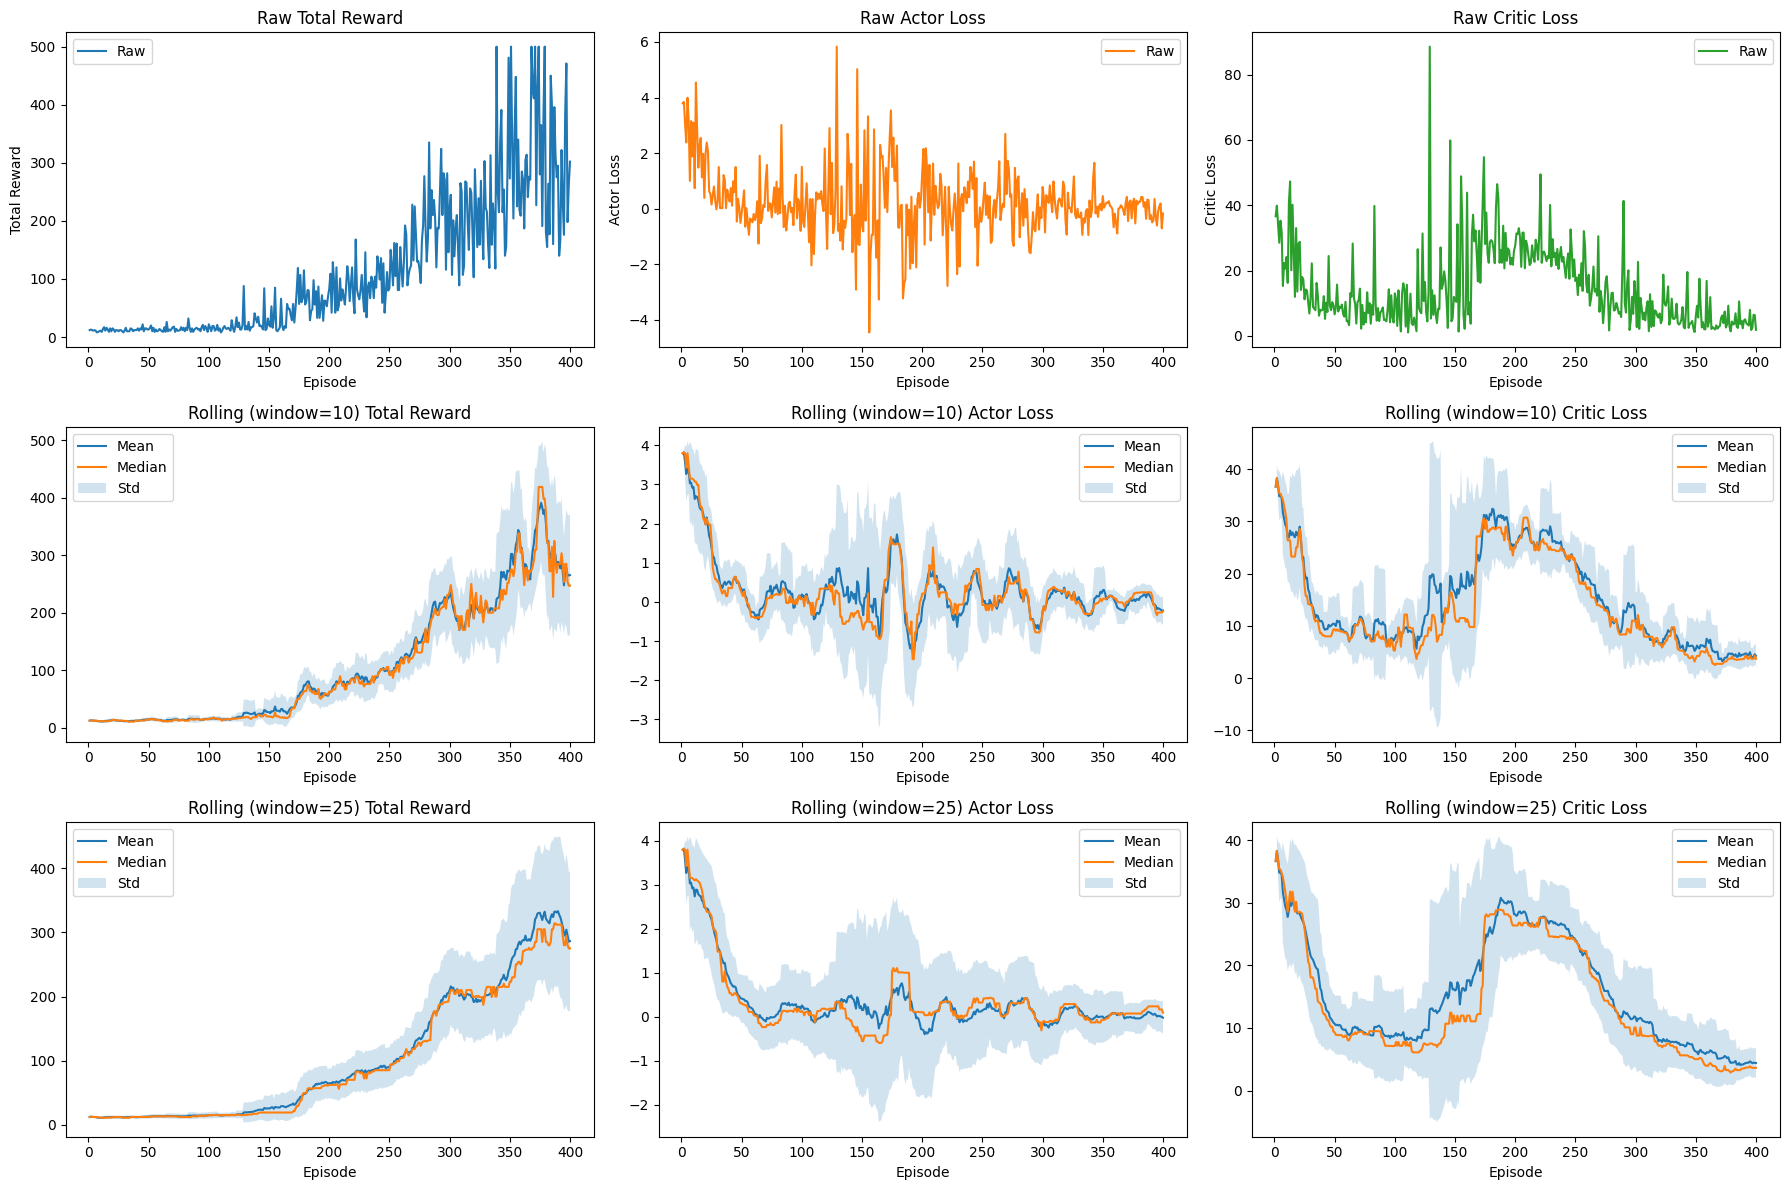

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        "num_episodes": 400,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 750,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 12.00	Actor Loss: 3.8942	Critic Loss: 35.2809
Episode 20	Total Reward: 13.00	Actor Loss: 3.8906	Critic Loss: 37.9931
Episode 30	Total Reward: 23.00	Actor Loss: 5.6447	Critic Loss: 81.7054
Episode 40	Total Reward: 19.00	Actor Loss: 4.8152	Critic Loss: 60.2104
Episode 50	Total Reward: 31.00	Actor Loss: 6.5424	Critic Loss: 108.7095
Episode 60	Total Reward: 51.00	Actor Loss: 8.4425	Critic Loss: 170.8530
Episode 70	Total Reward: 19.00	Actor Loss: 4.2375	Critic Loss: 50.0347
Episode 80	Total Reward: 14.00	Actor Loss: 2.8929	Critic Loss: 26.3972
Episode 90	Total Reward: 24.00	Actor Loss: 4.6322	Critic Loss: 60.6333
Episode 100	Total Reward: 21.00	Actor Loss: 4.0854	Critic Loss: 46.3338
Episode 110	Total Reward: 26.00	Actor Loss: 4.2332	Critic Loss: 55.9513
Episode 120	Total Reward: 26.00	Actor Loss: 4.0940	Critic Loss: 52.4853
Episode 130	Total Reward: 26.00	Actor Loss: 3.6274	Critic Loss: 44.8793
Episode 140	Total Reward: 13.00	Actor Loss: 0.7659	Critic Loss: 9.7828


NO CONVERGE, TOMA DEMASIADO TIEMPO EN AVANZAR EPISODIOS

2025-03-28 13:46:18.164552: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 11.00	Actor Loss: 1.5351	Critic Loss: 14.9948
Episode 20	Total Reward: 13.00	Actor Loss: 1.2098	Critic Loss: 12.2114
Episode 30	Total Reward: 17.00	Actor Loss: 1.0895	Critic Loss: 14.1444
Episode 40	Total Reward: 11.00	Actor Loss: 0.2094	Critic Loss: 3.9950
Episode 50	Total Reward: 13.00	Actor Loss: -0.2577	Critic Loss: 5.3818
Episode 60	Total Reward: 12.00	Actor Loss: 0.0408	Critic Loss: 1.9726
Episode 70	Total Reward: 10.00	Actor Loss: 0.0507	Critic Loss: 0.7439
Episode 80	Total Reward: 10.00	Actor Loss: 0.0648	Critic Loss: 0.5007
Episode 90	Total Reward: 21.00	Actor Loss: 0.7866	Critic Loss: 4.1879
Episode 100	Total Reward: 9.00	Actor Loss: -0.0809	Critic Loss: 0.5464
Episode 110	Total Reward: 19.00	Actor Loss: 0.4889	Critic Loss: 1.4744
Episode 120	Total Reward: 10.00	Actor Loss: -0.0381	Critic Loss: 0.0381
Episode 130	Total Reward: 22.00	Actor Loss: 0.4113	Critic Loss: 1.0847
Episode 140	Total Reward: 14.00	Actor Loss: -0.1433	Critic Loss: 0.2748
Episode 1

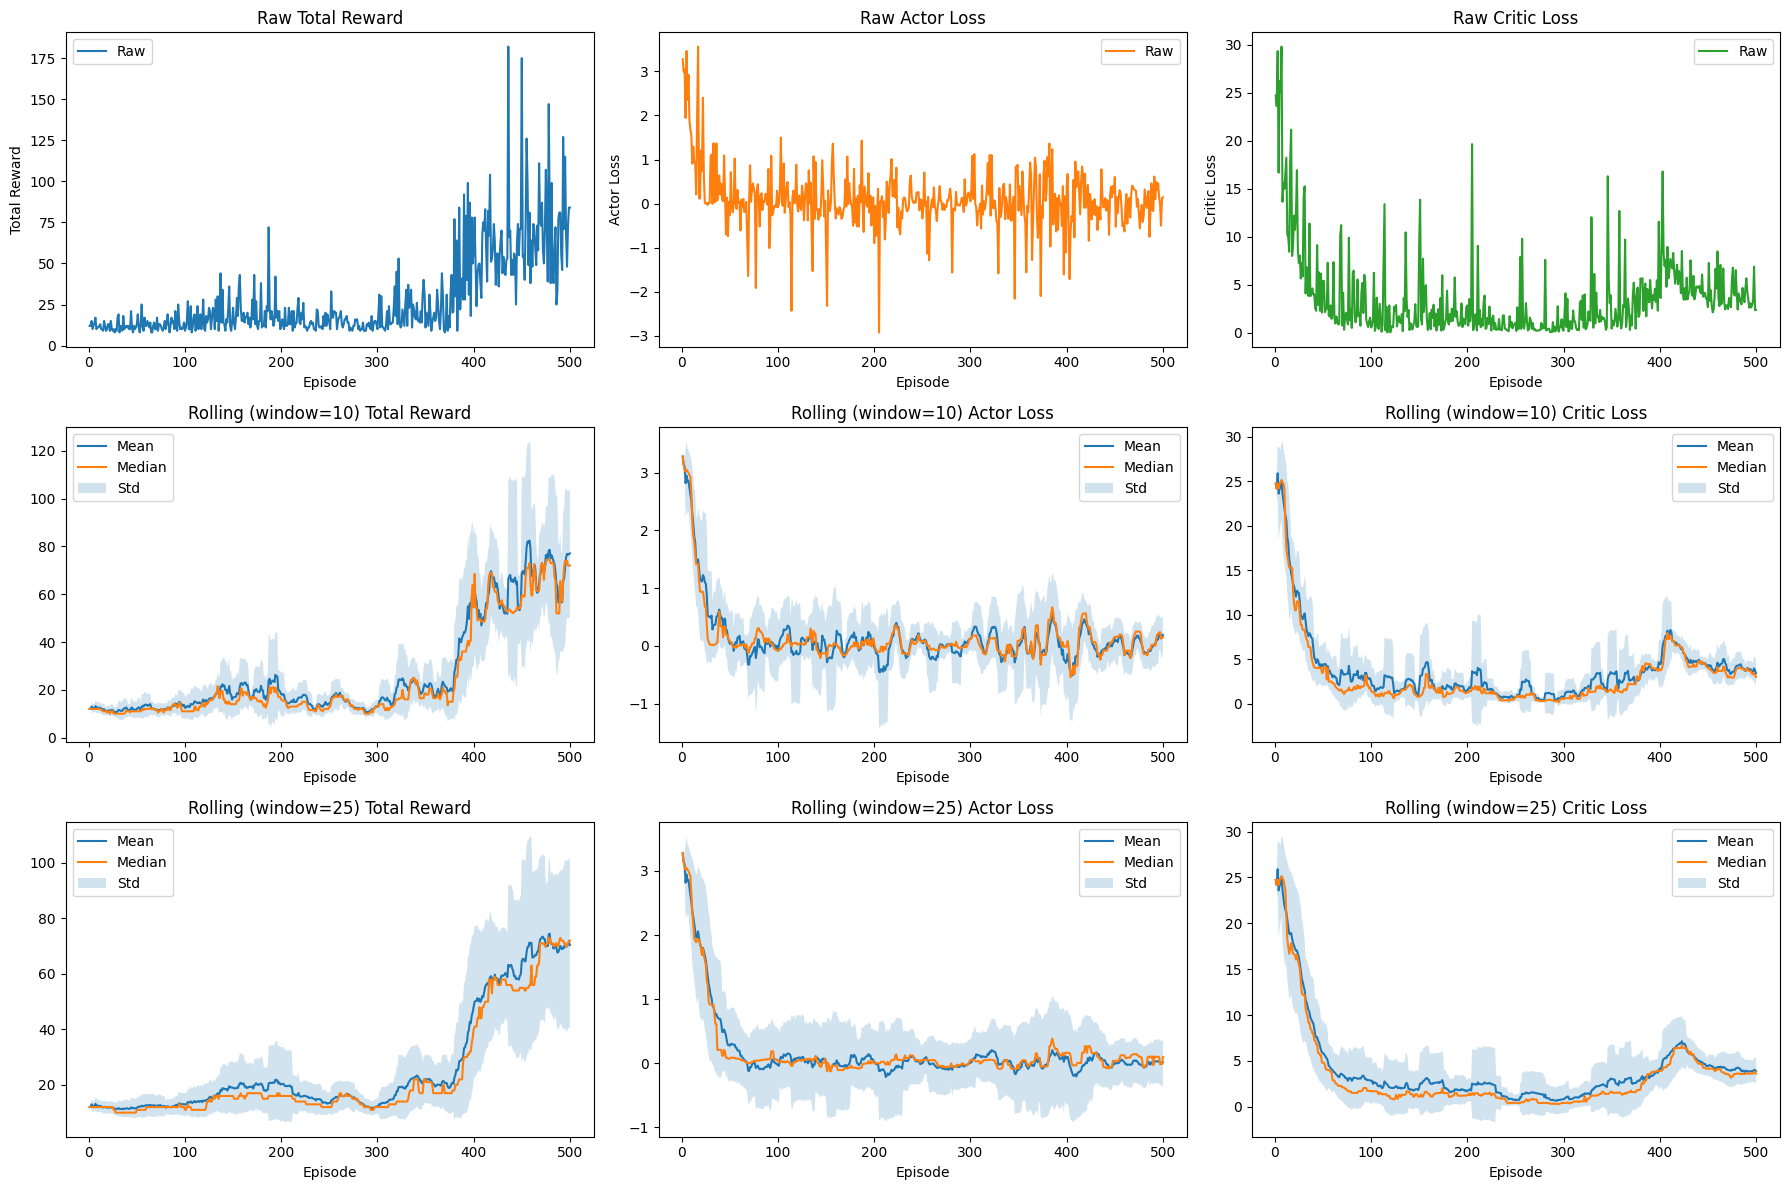

In [2]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        "num_episodes": 500,
        "gamma": 0.90,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        "num_episodes": 750,
        "gamma": 0.90,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 12.00	Actor Loss: 1.9657	Critic Loss: 16.1828
Episode 20	Total Reward: 14.00	Actor Loss: 0.8413	Critic Loss: 11.2380
Episode 30	Total Reward: 13.00	Actor Loss: 0.7690	Critic Loss: 9.9639
Episode 40	Total Reward: 16.00	Actor Loss: 0.8733	Critic Loss: 8.0263
Episode 50	Total Reward: 10.00	Actor Loss: -0.1026	Critic Loss: 2.2031
Episode 60	Total Reward: 23.00	Actor Loss: 0.3600	Critic Loss: 2.6147
Episode 70	Total Reward: 37.00	Actor Loss: 0.3992	Critic Loss: 3.1211
Episode 80	Total Reward: 18.00	Actor Loss: -0.6017	Critic Loss: 1.1413
Episode 90	Total Reward: 56.00	Actor Loss: 0.4414	Critic Loss: 3.9930
Episode 100	Total Reward: 53.00	Actor Loss: 0.4483	Critic Loss: 4.3592
Episode 110	Total Reward: 76.00	Actor Loss: 1.0844	Critic Loss: 5.8091
Episode 120	Total Reward: 26.00	Actor Loss: -0.6139	Critic Loss: 4.3020
Episode 130	Total Reward: 40.00	Actor Loss: -0.1779	Critic Loss: 2.9649
Episode 140	Total Reward: 72.00	Actor Loss: 0.7630	Critic Loss: 3.9643
Episode 1

TARDA DEMASIADO EN CONVERGER, EL MEJOR ES EL PRIMER MODELO

2025-03-28 14:57:25.812511: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 12.00	Actor Loss: 1.9629	Critic Loss: 27.1198
Episode 20	Total Reward: 10.00	Actor Loss: 1.5719	Critic Loss: 16.0560
Episode 30	Total Reward: 10.00	Actor Loss: 0.0573	Critic Loss: 8.3696
Episode 40	Total Reward: 9.00	Actor Loss: -0.3543	Critic Loss: 6.8211
Episode 50	Total Reward: 11.00	Actor Loss: -0.2636	Critic Loss: 5.7573
Episode 60	Total Reward: 14.00	Actor Loss: 0.2511	Critic Loss: 5.1136
Episode 70	Total Reward: 13.00	Actor Loss: -0.9972	Critic Loss: 15.1203
Episode 80	Total Reward: 10.00	Actor Loss: -1.1115	Critic Loss: 10.7002
Episode 90	Total Reward: 9.00	Actor Loss: -0.0504	Critic Loss: 1.4924
Episode 100	Total Reward: 9.00	Actor Loss: -0.2422	Critic Loss: 2.0139
Episode 110	Total Reward: 9.00	Actor Loss: -0.1359	Critic Loss: 0.4423
Episode 120	Total Reward: 9.00	Actor Loss: -0.1448	Critic Loss: 0.2481
Episode 130	Total Reward: 11.00	Actor Loss: -0.5291	Critic Loss: 2.0201
Episode 140	Total Reward: 25.00	Actor Loss: 0.6533	Critic Loss: 12.3142
Episod

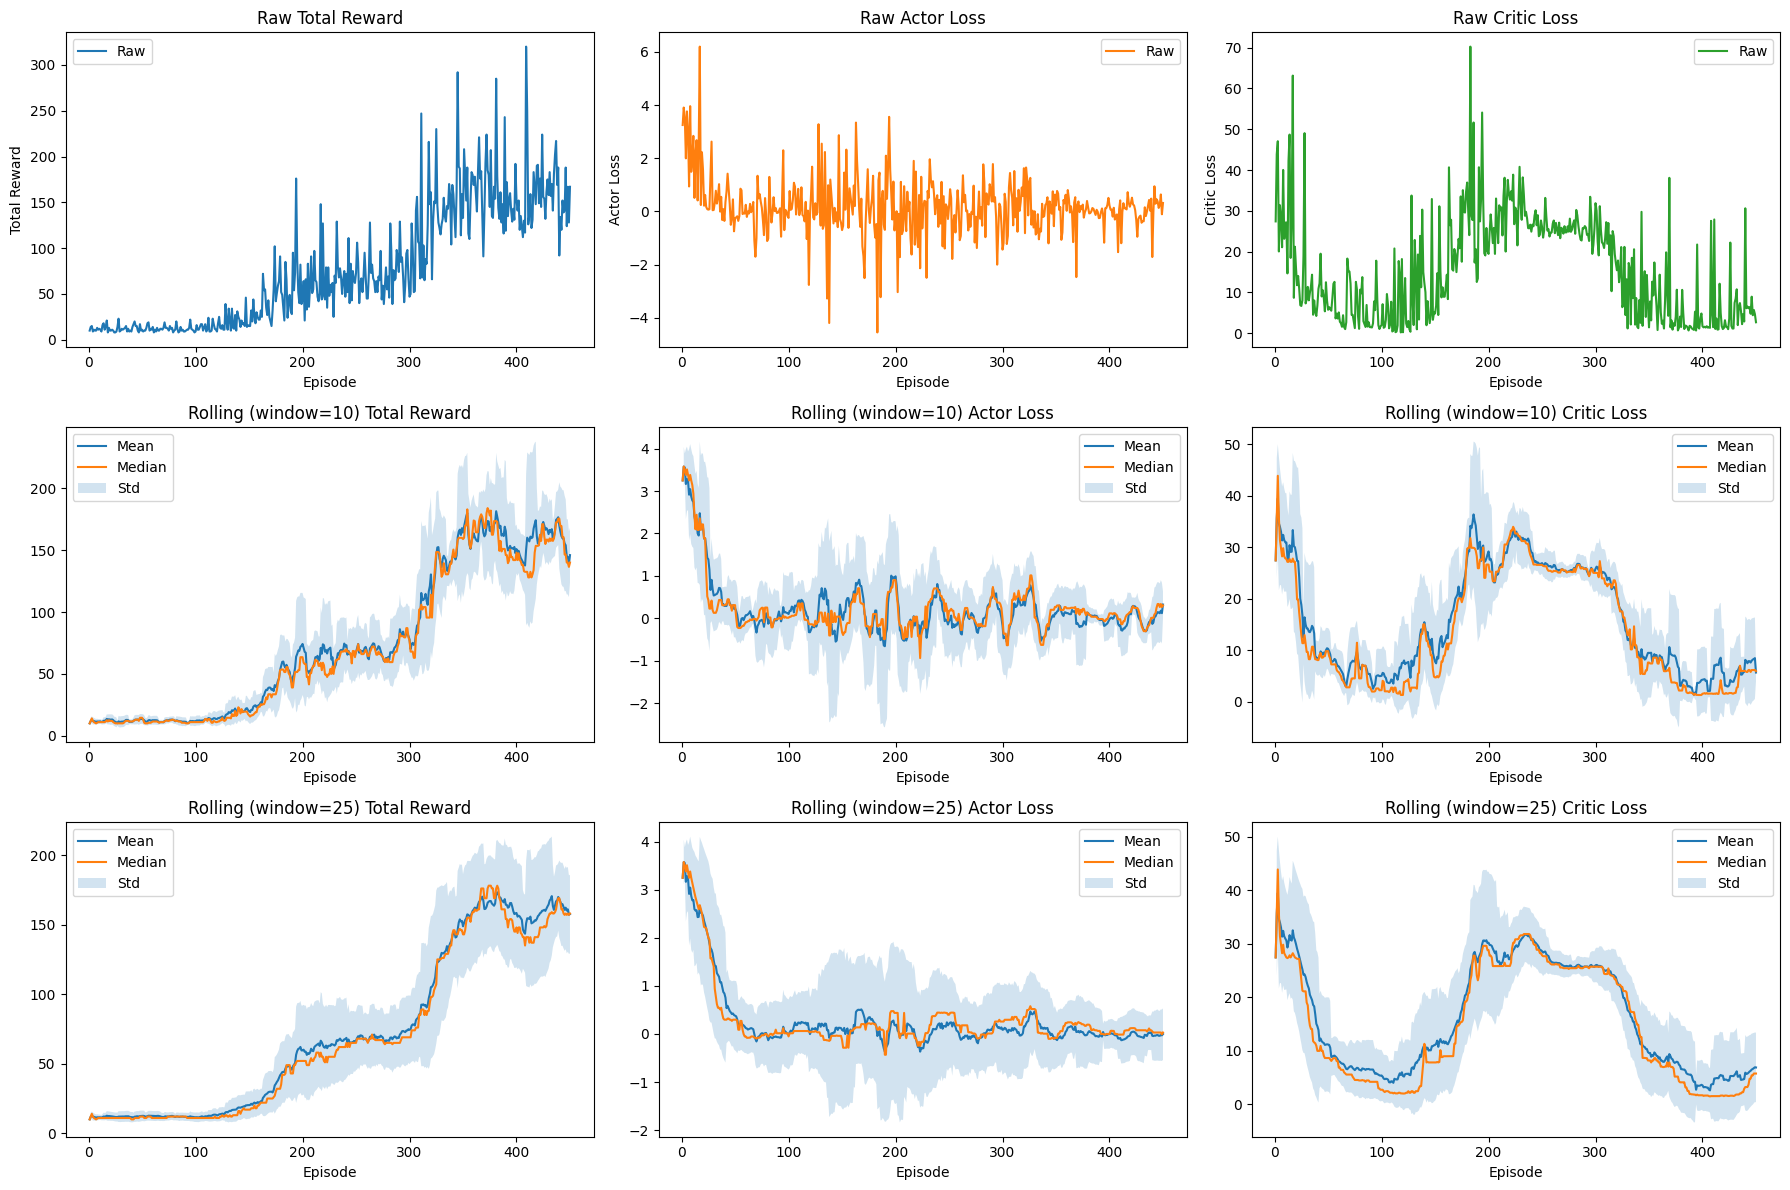

In [3]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 5e-3,
        "critic_lr": 5e-3,
        "num_episodes": 450,
        "gamma": 0.95,
        "noise_std": 0.01,
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)